In [1]:
import seaborn as sb
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import scipy.stats as st
from scipy.stats import norm
sb.set()

import matplotlib as mpl
sb.set(rc = {'figure.figsize':(15,8)})
mpl.rcParams['figure.dpi'] = 300

In [2]:
#loading dataset
Data=pd.read_excel("BNSweekly.xlsx")
Data.set_index('Date')

# defining constants for assignment  
tau, S_0, r, K_p, K_c, sig, mu,tau_0 = (11/52-4/52), 67.45, 0.03, 64, 70, 0.2, 0.045,11/52


"""This block defines the parameters for the Black Scholes model"""
def d1(S,k,tau):
    return(np.log(S/k)+(r+0.5*sig**2)*tau)/(sig*np.sqrt(tau))

def d2(S,k,tau):
    return d1(S,k,tau)-sig*np.sqrt(tau)

def delta_c(d1): #partial derivative of call
    return norm.cdf(d1)

def delta_p(d1): ##partial derivative of call
    return norm.cdf(d1) - 1

def gamma(S,k,tau): #gamma is the same for both call and put options
    return norm.pdf(d1(S,k,tau))/(S*sig*np.sqrt(tau))

def Theta_p(S): #time maturity partial for put option
    aux1 = (-S*norm.pdf(d1(S,K_p,tau_0))*sig)/(2*np.sqrt(tau_0))
    aux2 = r*K_p*np.exp(-r*tau_0)*norm.cdf(-d2(S,K_p,tau_0))
    return aux1+aux2

def Theta_c(S): #time maturity partial for call option
    aux1 = (-S*norm.pdf(d1(S,K_c,tau_0))*sig)/(2*np.sqrt(tau_0))
    aux2 = -r*K_c*np.exp(-r*tau_0)*norm.cdf(d2(S,K_c,tau_0))
    return aux1+aux2

def loss_approx(s):
    x=delta_p(d1(S_0,K_p,tau_0))*(s-S_0)+0.5*gamma(S_0,K_p,tau_0)*(s-S_0)**2+Theta_p(S_0)*(tau-tau_0)
    y=delta_c(d1(S_0,K_c,tau_0))*(s-S_0)+0.5*gamma(S_0,K_c,tau_0)*(s-S_0)**2+Theta_c(S_0)*(tau-tau_0)
    return -10000*((s-S_0)+x-y)

def loss(s):
    x=K_p*np.exp(-r*tau)*norm.cdf(-d2(s,K_p,tau))-s*norm.cdf(-d1(s,K_p,tau)) #put option price via BS
    y=s*norm.cdf(d1(s,K_c,tau))-K_c*np.exp(-r*tau)*norm.cdf(d2(s,K_c,tau))#call option price via BS                                                     
    return -10000*(s+x-y-IC)

"""Option intial cost computed using BS"""
C_0 = (
    S_0*norm.cdf(d1(S_0,K_c,tau_0))-
    K_c*np.exp(-r*tau_0)*norm.cdf(d2(S_0,K_c,tau_0))
    )

P_0 = (
    K_p*np.exp(-r*tau_0)*norm.cdf(-d2(S_0,K_p,tau_0))-
    S_0*norm.cdf(-d1(S_0,K_p,tau_0))
    )
IC=S_0+P_0-C_0

### 1c)

In [3]:
"""Generating returns and simulated stock price via historical simulation"""

Agassi=Data[::4]
Agassi['Returns']=Agassi['BNS'].pct_change()
Agassi['Stock']=S_0*(1+Agassi['Returns']) #np.log(Agassi['Returns'])
Agassi['Loss']=Agassi['Stock'].apply(lambda x:loss(x))
Agassi['Loss_Approximate']=Agassi['Stock'].apply(lambda x:loss_approx(x))
Agassi.dropna(inplace=True)
Agassi

/var/folders/1n/9kywvn8s3271zcw0fgmct4hw0000gn/T/ipykernel_28234/472590767.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Agassi['Returns']=Agassi['BNS'].pct_change()
/var/folders/1n/9kywvn8s3271zcw0fgmct4hw0000gn/T/ipykernel_28234/472590767.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Agassi['Stock']=S_0*(1+Agassi['Returns']) #np.log(Agassi['Returns'])
/var/folders/1n/9kywvn8s3271zcw0fgmct4hw0000gn/T/ipykernel_28234/472590767.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy 

,Date,BNS,Returns,Stock,Loss,Loss_Approximate
4,2017-10-30,65.070412,0.048817,70.742685,-15041.086303,-9767.841935
8,2017-11-27,63.662437,-0.021638,65.990536,4842.566122,7202.559178
12,2017-12-25,63.102348,-0.008798,66.856589,876.256221,3927.165969
16,2018-01-22,64.181152,0.017096,68.603132,-6876.765907,-2430.612046
20,2018-02-19,61.573364,-0.040632,64.709393,10561.928999,12197.090978
...,...,...,...,...,...,...
240,2022-05-09,78.720108,-0.048027,64.210560,12676.308565,14189.974513
244,2022-06-06,79.564888,0.010731,68.173836,-5033.208164,-898.570795
248,2022-07-04,73.457214,-0.076763,62.272306,19888.060514,22189.796881
252,2022-08-01,77.239799,0.051494,70.923251,-15636.835496,-10364.328112


#### ii) Histogram of Losses

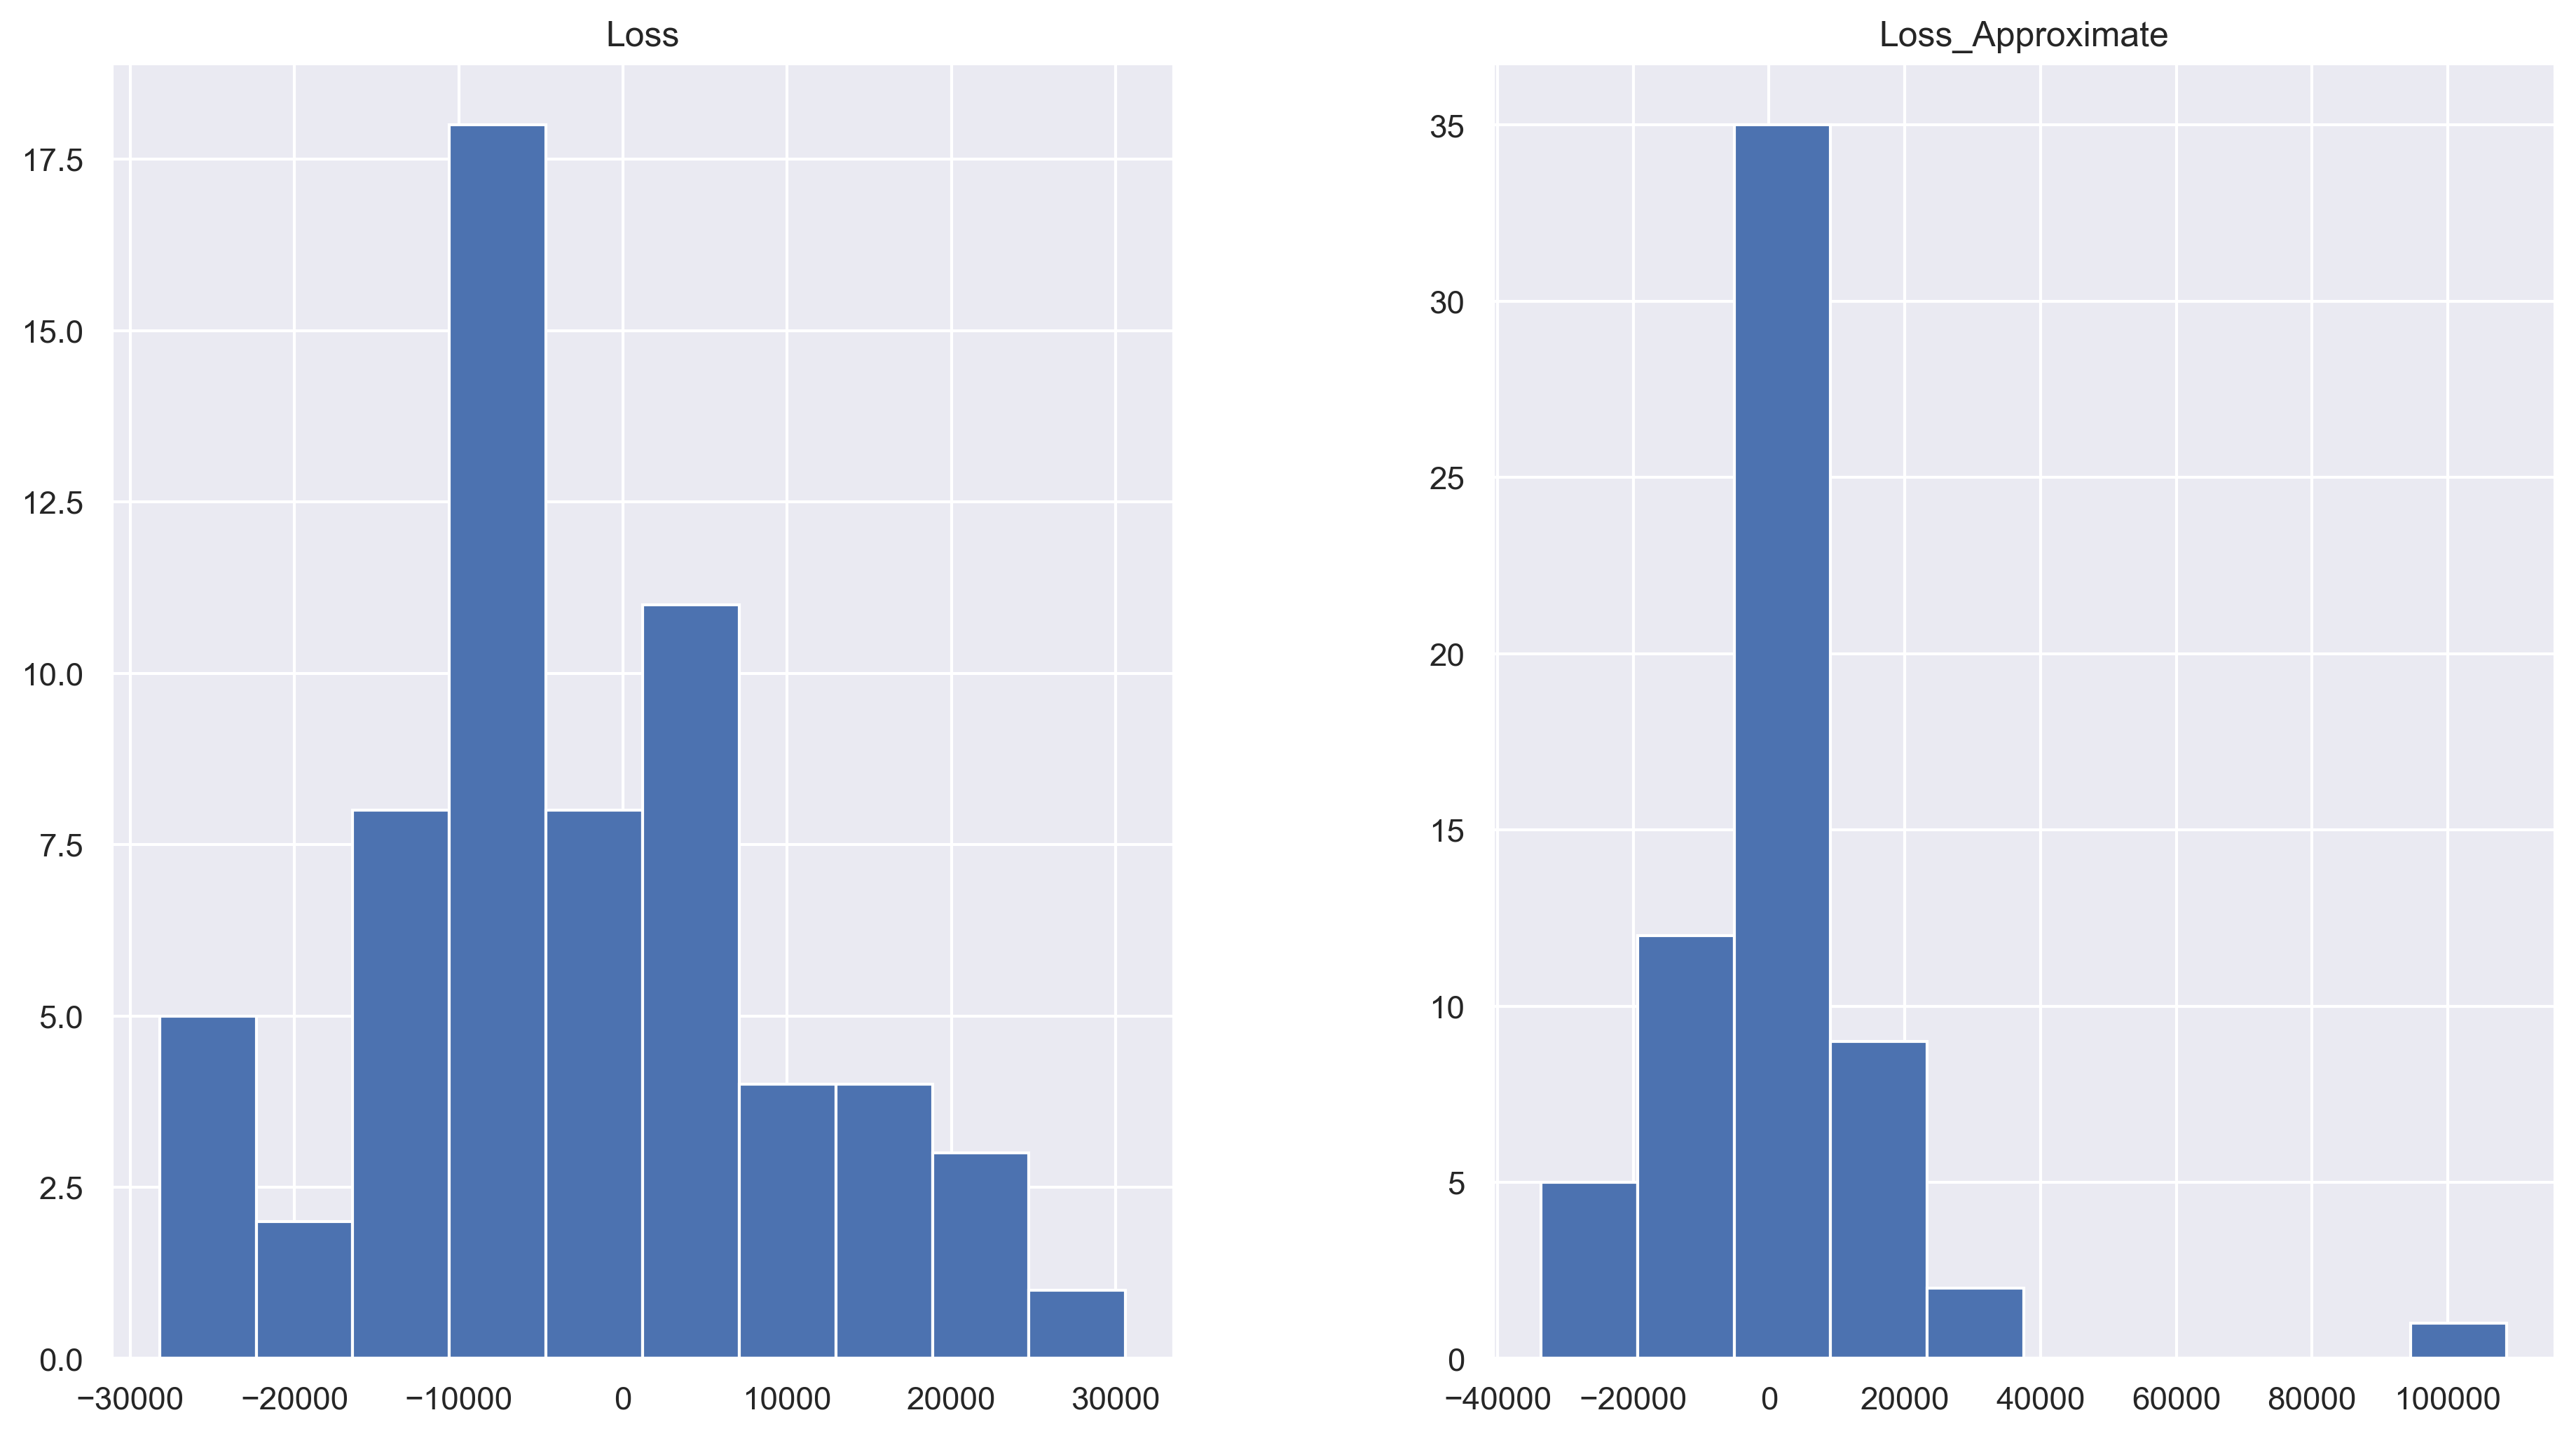

In [4]:
Agassi.hist(['Loss','Loss_Approximate']);

#### ii) VaR and ES Table

In [5]:
temp=pd.DataFrame(index=['Loss','Loss_Approximate'])
temp['90% VaR'] = [
        Agassi.sort_values(by=['Loss']).iloc[58]['Loss'],
        Agassi.sort_values(by=['Loss_Approximate']).iloc[58]['Loss_Approximate']
                        ]
temp['ES'] = [
        Agassi.query("Loss >= 14295.239")['Loss'].mean(),
        Agassi.query("Loss_Approximate >= 15796.150")['Loss_Approximate'].mean()
    
]
temp.round(3)

,90% VaR,ES
Loss,14295.239,21185.363
Loss_Approximate,15796.150,36201.059


#### 1d) Log Normal and MonteCarlo Simulation

In [6]:
Monte=pd.DataFrame()
T=4/52
Monte['U']=np.random.rand(10000)

In [7]:
Monte['Z']=Monte['U'].apply(lambda x:norm.ppf(x))
Monte['X_T']= (mu-(sig**2)/2)*T + sig*np.sqrt(T)*Monte['Z']
Monte['Stock']=S_0*np.exp(Monte['X_T'])
Monte['Loss'] = Monte['Stock'].apply(lambda x:loss(x))
Monte['Loss_Approx'] = Monte['Stock'].apply(lambda x:loss_approx(x))

#### i) Histogram of Losses

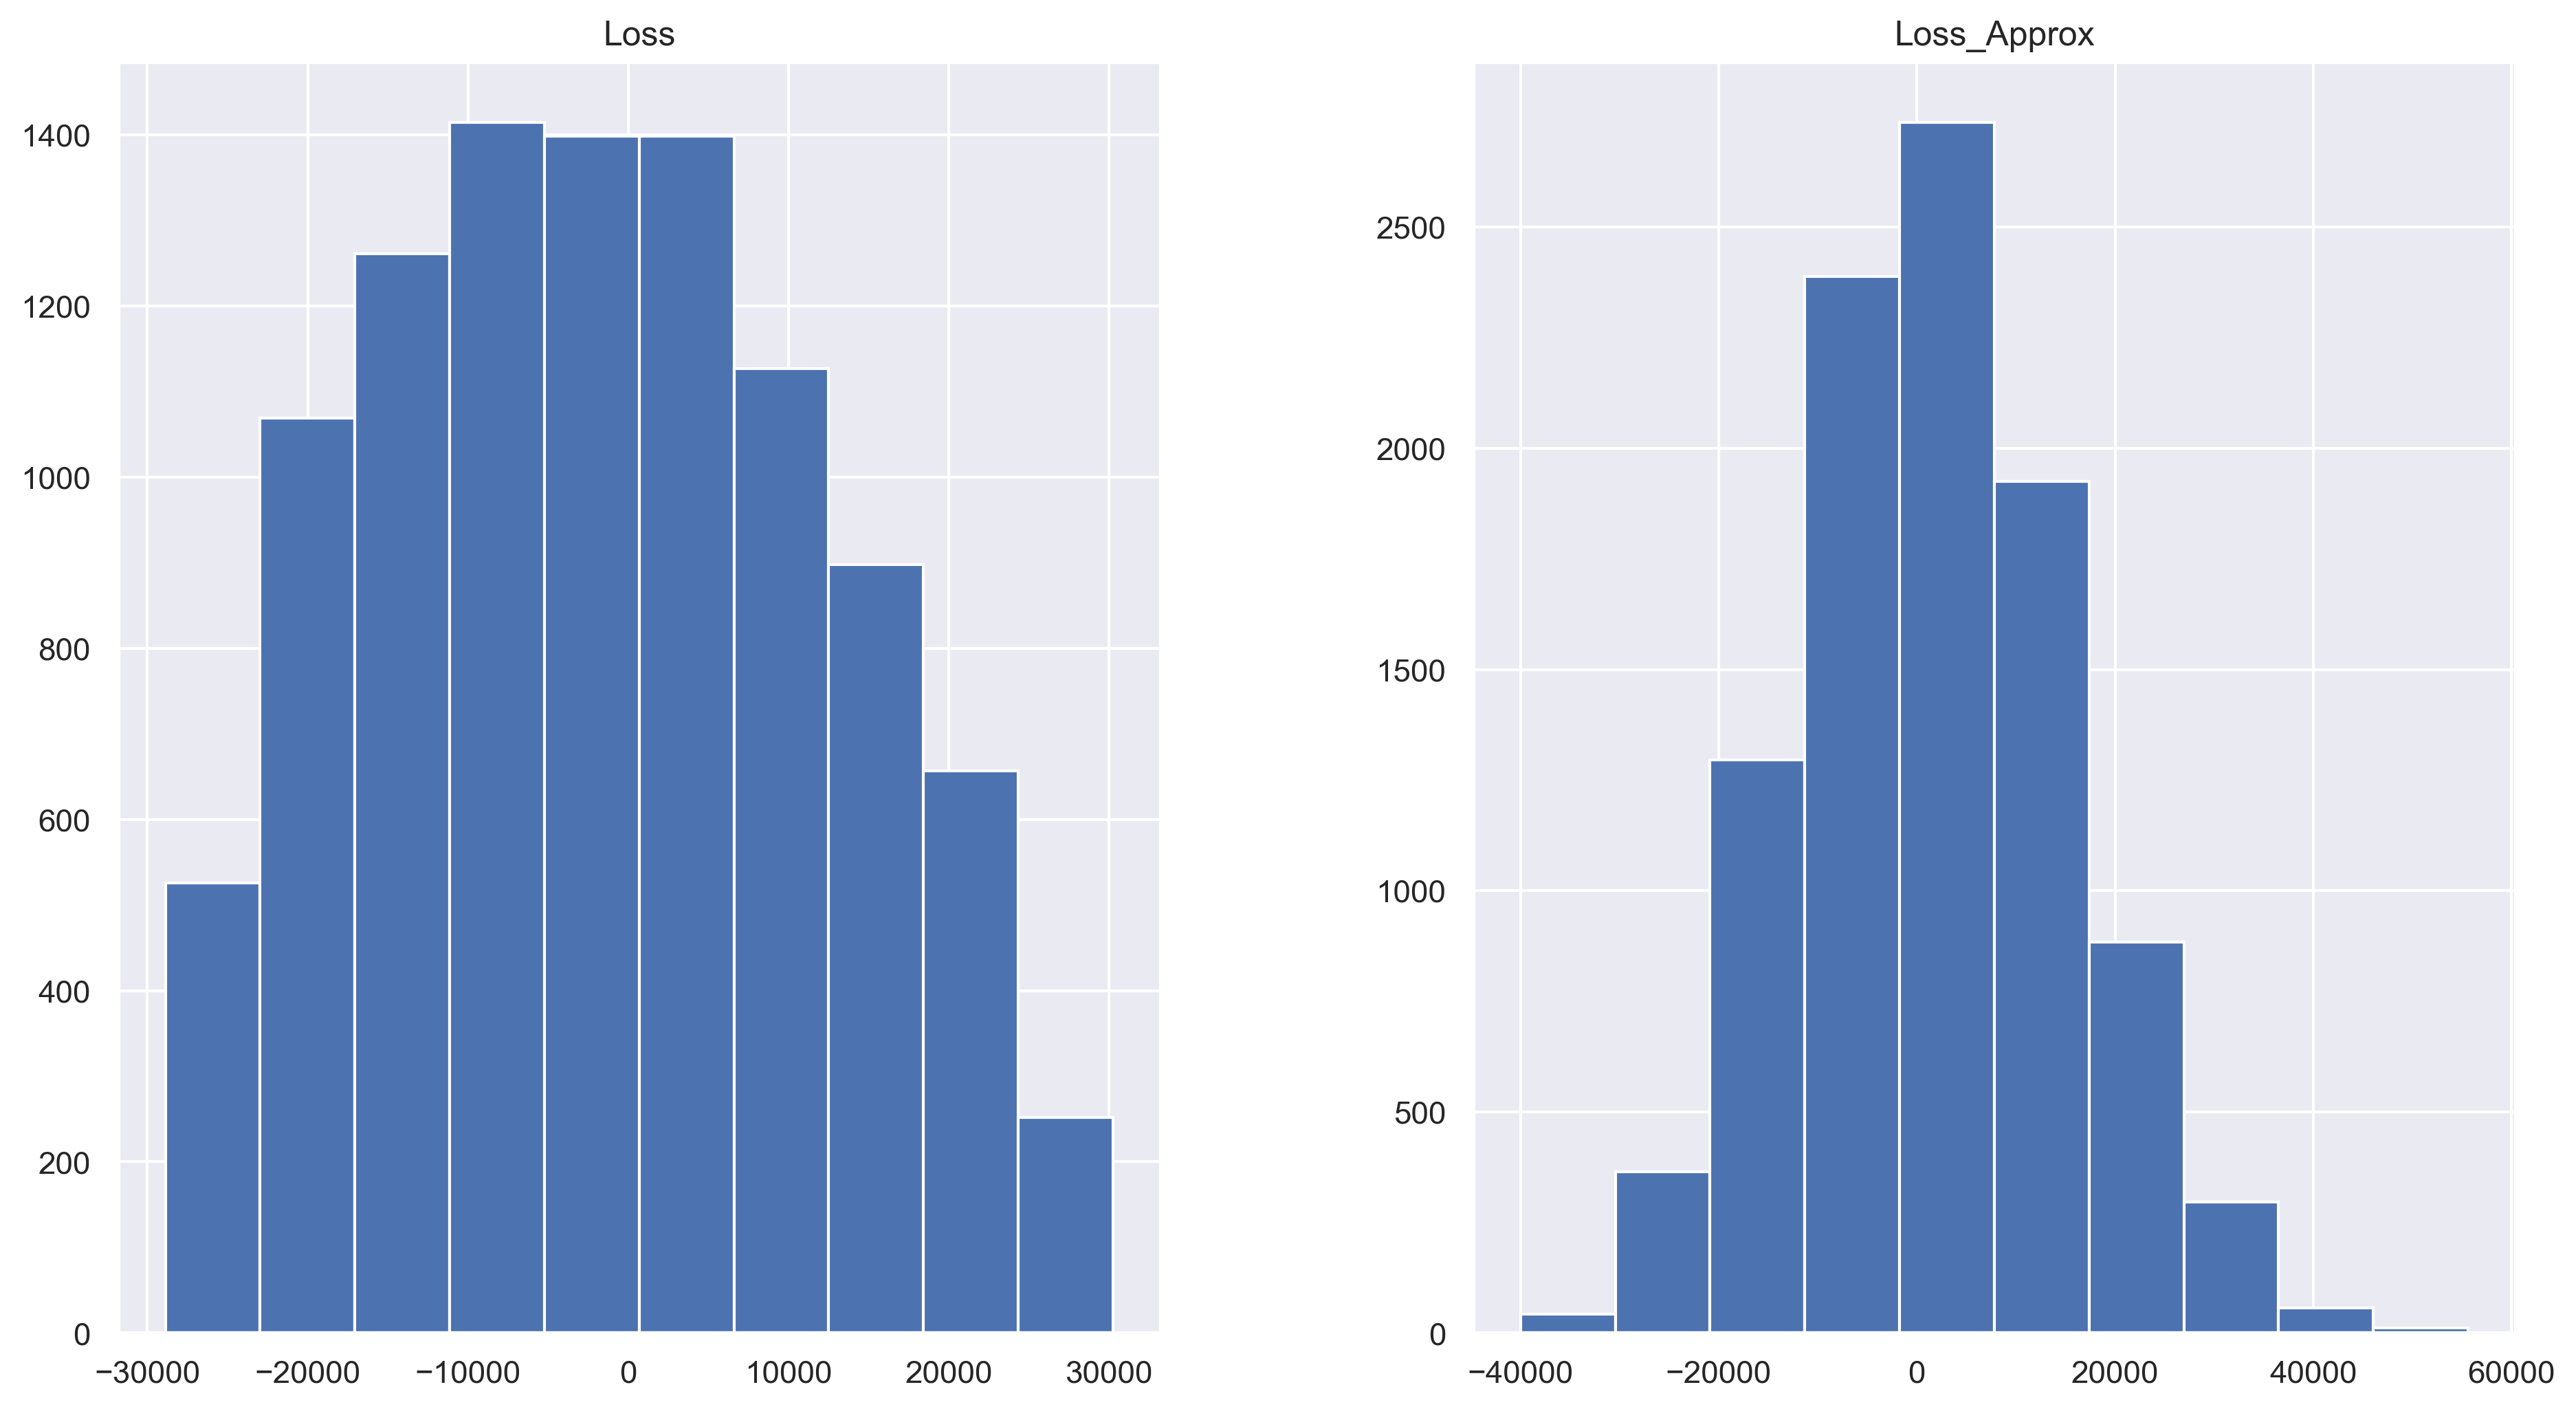

In [8]:
Monte.hist(['Loss','Loss_Approx']);

In [9]:
temp1=pd.DataFrame(index=['Loss','Loss_Approx'])
temp1['90% VaR'] = [
        Monte.sort_values(by=['Loss']).iloc[9001]['Loss'],
        Monte.sort_values(by=['Loss_Approx']).iloc[9001]['Loss_Approx']
                        ]
temp1['ES'] = [
        Monte.query("Loss >= 17784.424")['Loss'].mean(),
        Monte.query("Loss_Approx >= 19589.186")['Loss_Approx'].mean()
    
]
temp1.round(3)

,90% VaR,ES
Loss,17649.423,22325.942
Loss_Approx,19431.783,26566.439


#### 1e) Comparing Historical vs Monte Carlo Simulations

The losses and corresponding risk measures generated from the Monte Carlo situation are much lower than those generated from the historical simualtion.

In [10]:
display(temp,temp1)

,90% VaR,ES
Loss,14295.239059,21185.362865
Loss_Approximate,15796.150037,36201.059477


,90% VaR,ES
Loss,17649.423023,22325.942087
Loss_Approx,19431.782857,26566.438656


### 2. Confidence Intervals for VaR
#### a) & b) 

In [11]:
#CI for Historical Simulated Loss
x=norm.ppf(0.90, loc=Agassi['Loss'].mean(), scale=Agassi['Loss'].std())
y=(1/norm.pdf(x,Agassi['Loss'].mean(),Agassi['Loss'].std()))*np.sqrt(0.90*0.10/len(Agassi))
CI_Hist=[temp.loc['Loss'][0]-1.96*y,temp.loc['Loss'][0]+1.96*y]

#CI for Monte Carlo Simulated Loss
w=norm.ppf(0.90, loc=Monte['Loss'].mean(), scale=Monte['Loss'].std())
z=(1/norm.pdf(w,Monte['Loss'].mean(),Monte['Loss'].std()))*np.sqrt(0.90*0.10/len(Monte))
CI_Monte=[temp1.loc['Loss'][0]-1.96*z,temp1.loc['Loss'][0]+1.96*z]

Pres=pd.DataFrame(index=['Historical Simulation', 'Monte Carlo Simulation'])
Pres['90% Var']=[temp.loc['Loss'][0],temp1.loc['Loss'][0]]
Pres['95% CI']=[CI_Hist,CI_Monte]
Pres['95% CI']=Pres['95% CI'].apply(lambda x:np.round(x,3))
Pres.round(3)


,90% Var,95% CI
Historical Simulation,14295.239,"[8993.254, 19597.224]"
Monte Carlo Simulation,17649.423,"[17186.147, 18112.699]"
